# Final Project: Life With John Mayer Analysis
In November 2023, SiriusXM launched Life with John Mayer. Created by the GRAMMY Award-winning musician, songwriter, and guitar player, the station is touted as one “…not defined defined by genre, but by time of day as well as day of week. It’s an ever-evolving world of music built from Mayer’s classics, collaborations, and never-before-heard material, blended in with the music he loves.”

For my final project, I decided to take a look at data for a week's worth of music played on this station **between March 10 and March 16**. Are there certain artists that get played on this station more than others? How does the type of music change specifically throughout the day?

Fortunately, I was able to access this data with the help of 2 APIs: one that pulled tracks played on the station and one via Spotify that added some metadata about each song. Information on each API is described below.

In [455]:
#import packages
import os
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import datetime
import time

## Building the Master Dataset
The final dataset is pulled from 2 different sources, a Sirius XM API and the Spotify Web API. Below outlines both the process of building those datasets.

### Sirius XM Playlist Data
Step one of building the master dataset began with the Sirius XM API. The link to this API can be found [here](https://xmplaylist.com/api/documentation/static/index.html). Specifically, there is a /api/station/{station_name} endpoint that I used to pull data about the songs played on the station. While I would've liked to have used the requests package to automate the process of retrieving radio play data from this API, I could not do so as the Cloudflare protections on this website kept preventing me from making calls with the requests package. However, I was able to make calls using Postman! Thus began a very manual process of calling the API with Postman, copying the 50 or so songs the API would respond with into a JSON file in Sublime Text, and then paginating through the API by entering the earliest timestamp into the next API call until I got ~ a week's work of songs played on the station between 3/10 and 3/16.

In [466]:
r = requests.get('https://xmplaylist.com/api/station/lifewithjohnmayer')
print(r.status_code, r.reason)

403 Forbidden


In [361]:
# Read in the manually created JSON file, convert the JSON file into a DataFrame
f = open('/Users/mattdemichiel/Documents/Learning Things/Data_CompSci/dss-122/Final Project/ljm_tracks.json')
df = pd.DataFrame.from_records(json.load(f), exclude=['links','id'])

In [362]:
df.head()

,start_time,track,spotify
0,2024-03-16T20:41:47.000Z,"{'id': 'GDCA-109738510-001', 'name': 'Madwoman...","{'spotify_id': '4m9W0S0DHx4uGnsgDc5xgl', 'prev..."
1,2024-03-16T20:37:39.000Z,"{'id': 'DDCA-000499795-003', 'name': 'Get Read...","{'spotify_id': '4CoGNqLap7UGU5Q3VdKug0', 'prev..."
2,2024-03-16T20:32:29.000Z,"{'id': 'DDCA-000843865-004', 'name': 'Damn I W...","{'spotify_id': '7kmfQ2QHwGqRCxVHDv5mzo', 'prev..."
3,2024-03-16T20:27:45.000Z,"{'id': 'GDCA-109009837-001', 'name': '3X5', 'a...","{'spotify_id': '2Knlcf82LF6hp6Bf0gldtN', 'prev..."
4,2024-03-16T20:20:34.000Z,"{'id': 'GDCA-108207046-002', 'name': 'Layla', ...","{'spotify_id': '2kkvB3RNRzwjFdGhaUA0tz', 'prev..."


In [5]:
# the JSON responses were nested, so I had to build functions to unpack the data in the the columns
# below is an example of data nested inside of the track column
df['track'][0]

{'id': 'GDCA-109738510-001',
 'name': 'Madwoman',
 'artists': ['Annika Bennett'],
 'created_at': '2023-11-22T21:46:29.102Z'}

In [363]:
#function to extract info from track column
def extract_track_info(dictionary):
    track_name = dictionary['name']
    artist = dictionary['artists'][0]
    return track_name, artist

#function to extract spotify id for joining
def extract_spotify_id(dictionary):
    try:
        spotify_id = dictionary['spotify_id']
    except:
        spotify_id = np.nan
    return spotify_id

In [364]:
# using a lambda expression, extract relevant track info and give them their own column
df[['track_name','artist']] = df['track'].apply(lambda x: pd.Series(extract_track_info(x)))

# again using a lambda expression, extract the spotify_id, which will be used for pinging the spotify api
df['spotify_id'] = df['spotify'].apply(lambda x: pd.Series(extract_spotify_id(x)))

# time series is an important comoponent of this data, so i first converted start_time to datetime as well as
# created a column adjusted for my timezone
df['start_time'] = pd.to_datetime(df['start_time'])
df['start_time_est'] = df['start_time'].dt.tz_convert('US/Eastern')

In [365]:
# keeping only the most relevant columns and sorting ascending by start time
tracks = df[['start_time','start_time_est','track_name','artist','spotify_id']]
tracks = tracks.sort_values('start_time')

In [366]:
tracks.head()

,start_time,start_time_est,track_name,artist,spotify_id
2327,2024-03-10 07:18:14+00:00,2024-03-10 03:18:14-04:00,Going To California,Led Zeppelin,70gbuMqwNBE2Y5rkQJE9By
2326,2024-03-10 07:21:39+00:00,2024-03-10 03:21:39-04:00,I'll Be Seeing You,Billie Holiday,4smkJW6uzoHxGReZqqwHS5
2325,2024-03-10 07:25:20+00:00,2024-03-10 03:25:20-04:00,Unknown/Nth,Hozier,1ptwL6lZNLc654XAaHqcHb
2324,2024-03-10 07:29:54+00:00,2024-03-10 03:29:54-04:00,Some,Nils Frahm,617B8BzRj0qN4cx8ITXV5B
2323,2024-03-10 07:33:57+00:00,2024-03-10 03:33:57-04:00,When The Stars Go Blue,Ryan Adams,04rMpRstoJt3uvqyNGKczX


### Spotify Data
To add some extra color to this analysis, I decided to use song metadata courtesy of Spotify, who offers a host of different API endpoints for free! For this analysis, I utilized their audio_features endpoint, the documentation of which can be found [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). 

While I could've pulled directly from this endpoint, I discovered a lightweight Python library built specifically to call this API called [Spotipy](https://spotipy.readthedocs.io/en/2.22.1/). A lot of the code below is based off of going through that documentation.

In [468]:
#set up credentials for spotify api
#instructions here: https://spotipy.readthedocs.io/en/2.22.1/#getting-started
#exported my api client id and secret key in terminal
client_id = os.getenv("SPOTIPY_CLIENT_ID")
client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [469]:
# here is an example of what the api returns
sp.audio_features('70gbuMqwNBE2Y5rkQJE9By')

[{'danceability': 0.503,
  'energy': 0.265,
  'key': 2,
  'loudness': -15.913,
  'mode': 1,
  'speechiness': 0.0333,
  'acousticness': 0.943,
  'instrumentalness': 0.045,
  'liveness': 0.0867,
  'valence': 0.522,
  'tempo': 78.044,
  'type': 'audio_features',
  'id': '70gbuMqwNBE2Y5rkQJE9By',
  'uri': 'spotify:track:70gbuMqwNBE2Y5rkQJE9By',
  'track_href': 'https://api.spotify.com/v1/tracks/70gbuMqwNBE2Y5rkQJE9By',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/70gbuMqwNBE2Y5rkQJE9By',
  'duration_ms': 212161,
  'time_signature': 4}]

In [470]:
# create a list of unique spotify ids
spotify_ids = list(tracks['spotify_id'].dropna().unique())
len(spotify_ids)

1503

In [ ]:
# due to rate limit restrictions spotify places on their api, i had to take a somewhat roundabout approach to
# collecting the feature data. i iterated through the above list, and would one by one use spotipy to collect
# song feature data and append it to a list, and then wait 4 seconds so as to not hit the rate limit
audio_features = []
for spotify_id in spotify_ids:
    audio_features.append(sp.audio_features(spotify_id))
    time.sleep(4)
    
# i also slightly erred in the above loop, as i ended up with a list of lists of dictionaries
# the below fixed this b/c i'm not going through that for loop again, it took like 2 hrs
features = [feature[0] for feature in audio_features]

In [26]:
# create the dataframe
features_df = pd.DataFrame.from_records(features)

In [24]:
features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.503,0.26500,2,-15.913,1,0.0333,0.943,0.045000,0.0867,0.522,78.044,audio_features,70gbuMqwNBE2Y5rkQJE9By,spotify:track:70gbuMqwNBE2Y5rkQJE9By,https://api.spotify.com/v1/tracks/70gbuMqwNBE2...,https://api.spotify.com/v1/audio-analysis/70gb...,212161,4
1,0.355,0.03040,1,-20.479,1,0.0361,0.989,0.055500,0.1160,0.188,90.495,audio_features,4smkJW6uzoHxGReZqqwHS5,spotify:track:4smkJW6uzoHxGReZqqwHS5,https://api.spotify.com/v1/tracks/4smkJW6uzoHx...,https://api.spotify.com/v1/audio-analysis/4smk...,211533,3
2,0.475,0.17800,7,-9.976,1,0.0347,0.745,0.000189,0.0899,0.230,136.687,audio_features,1ptwL6lZNLc654XAaHqcHb,spotify:track:1ptwL6lZNLc654XAaHqcHb,https://api.spotify.com/v1/tracks/1ptwL6lZNLc6...,https://api.spotify.com/v1/audio-analysis/1ptw...,280107,4
3,0.358,0.00527,6,-37.703,0,0.0407,0.985,0.890000,0.1080,0.212,103.791,audio_features,617B8BzRj0qN4cx8ITXV5B,spotify:track:617B8BzRj0qN4cx8ITXV5B,https://api.spotify.com/v1/tracks/617B8BzRj0qN...,https://api.spotify.com/v1/audio-analysis/617B...,198585,4
4,0.590,0.20800,10,-13.250,1,0.0316,0.466,0.000028,0.1150,0.293,90.084,audio_features,04rMpRstoJt3uvqyNGKczX,spotify:track:04rMpRstoJt3uvqyNGKczX,https://api.spotify.com/v1/tracks/04rMpRstoJt3...,https://api.spotify.com/v1/audio-analysis/04rM...,211667,4


In [26]:
# saving the dataframe in the future so i never have to run the for loop again
features_df.to_csv('ljm_audiofeatures.csv', index= False)

In [368]:
# code to read the above csv to a dataframe
features_df = pd.read_csv('ljm_audiofeatures.csv')

### Final Dataframe
With both datasets individually created, the final DataFrame can be built

In [385]:
# not every song in the Sirius API had a spotify id. so i used a left join to keep all track records
# even if they didn't have a spotify ID
tracks_df = tracks.join(features_df.set_index('id'), on='spotify_id', how = 'left')

In [386]:
tracks_df.shape

(2328, 22)

In [387]:
# looking through the dataset, I noticed an artist called (7.30.17. Digging into this i saw this was music from
# a live show john mayer did so this code fixes that
tracks_df.loc[tracks_df['artist'] == '(7.30.17 ', 'artist'] = 'John Mayer'

In [388]:
tracks_df.reset_index(inplace=True)

In [389]:
# getting rid of some unnecessary columns from the Spotify API
tracks_df.drop(['uri', 'track_href', 'analysis_url', 'type', 'index'], axis=1, inplace=True)

In [390]:
#the duration returned by the API is in milliseconds which is hard to decipher, so created a column for the
#duration in minutes
tracks_df['duration_minutes'] = round(tracks_df['duration_ms'] / 60000, 2)

In [391]:
# the final dataset for analysis
tracks_df.head()

,start_time,start_time_est,track_name,artist,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,duration_minutes
0,2024-03-10 07:18:14+00:00,2024-03-10 03:18:14-04:00,Going To California,Led Zeppelin,70gbuMqwNBE2Y5rkQJE9By,0.503,0.26500,2.0,-15.913,1.0,0.0333,0.943,0.045000,0.0867,0.522,78.044,212161.0,4.0,3.54
1,2024-03-10 07:21:39+00:00,2024-03-10 03:21:39-04:00,I'll Be Seeing You,Billie Holiday,4smkJW6uzoHxGReZqqwHS5,0.355,0.03040,1.0,-20.479,1.0,0.0361,0.989,0.055500,0.1160,0.188,90.495,211533.0,3.0,3.53
2,2024-03-10 07:25:20+00:00,2024-03-10 03:25:20-04:00,Unknown/Nth,Hozier,1ptwL6lZNLc654XAaHqcHb,0.475,0.17800,7.0,-9.976,1.0,0.0347,0.745,0.000189,0.0899,0.230,136.687,280107.0,4.0,4.67
3,2024-03-10 07:29:54+00:00,2024-03-10 03:29:54-04:00,Some,Nils Frahm,617B8BzRj0qN4cx8ITXV5B,0.358,0.00527,6.0,-37.703,0.0,0.0407,0.985,0.890000,0.1080,0.212,103.791,198585.0,4.0,3.31
4,2024-03-10 07:33:57+00:00,2024-03-10 03:33:57-04:00,When The Stars Go Blue,Ryan Adams,04rMpRstoJt3uvqyNGKczX,0.590,0.20800,10.0,-13.250,1.0,0.0316,0.466,0.000028,0.1150,0.293,90.084,211667.0,4.0,3.53


## Analysis Time!

In [376]:
tracks_df.dtypes

start_time                 datetime64[ns, UTC]
start_time_est      datetime64[ns, US/Eastern]
track_name                              object
artist                                  object
spotify_id                              object
danceability                           float64
energy                                 float64
key                                    float64
loudness                               float64
mode                                   float64
speechiness                            float64
acousticness                           float64
instrumentalness                       float64
liveness                               float64
valence                                float64
tempo                                  float64
duration_ms                            float64
time_signature                         float64
duration_minutes                       float64
dtype: object

Most of the columns in this dataset are type float. However it is worth calling out that the floats in the mode and key column are numerical representations of categorical variables. Documentation on the Spotify API page explains what these numbers represent.

In [377]:
#checking nulls
tracks_df.isna().sum()

start_time           0
start_time_est       0
track_name           0
artist               0
spotify_id          72
danceability        72
energy              72
key                 72
loudness            72
mode                72
speechiness         72
acousticness        72
instrumentalness    72
liveness            72
valence             72
tempo               72
duration_ms         72
time_signature      72
duration_minutes    72
dtype: int64

There were 72 tracks that did not have a Spotify ID, and therefore returned null features. When it comes time to do some modelling, I will likekly drop them from the dataset.

In [378]:
tracks_df.describe(include='all', datetime_is_numeric = True)

,start_time,start_time_est,track_name,artist,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,duration_minutes
count,2328,2328,2328,2328,2256,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000
unique,NaN,NaN,1546,838,1503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Yellow,John Mayer,1aiDlPLPljMFUylWjMZras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,5,147,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2024-03-13 13:12:22.302405376+00:00,2024-03-13 09:12:22.302405376-04:00,NaN,NaN,NaN,0.569620,0.518566,5.049645,-10.333546,0.759752,0.048556,0.403565,0.096846,0.165402,0.519770,117.960019,236502.339982,3.906915,3.941782
min,2024-03-10 07:18:14+00:00,2024-03-10 03:18:14-04:00,NaN,NaN,NaN,0.000000,0.000882,0.000000,-37.703000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,7229.000000,0.000000,0.120000
25%,2024-03-11 22:31:10.249999872+00:00,2024-03-11 18:31:10.249999872-04:00,NaN,NaN,NaN,0.471750,0.340750,2.000000,-12.758500,1.000000,0.030500,0.070675,0.000003,0.091875,0.325000,95.982000,191044.750000,4.000000,3.180000
50%,2024-03-13 12:47:53+00:00,2024-03-13 08:47:53-04:00,NaN,NaN,NaN,0.577000,0.530500,5.000000,-9.415500,1.000000,0.036200,0.320000,0.000243,0.114000,0.515000,115.342500,229093.000000,4.000000,3.820000
75%,2024-03-15 03:27:21.750000128+00:00,2024-03-14 23:27:21.750000128-04:00,NaN,NaN,NaN,0.667250,0.720000,8.000000,-6.674500,1.000000,0.047300,0.732000,0.016300,0.180000,0.717250,135.101750,269680.250000,4.000000,4.492500
max,2024-03-16 20:41:47+00:00,2024-03-16 16:41:47-04:00,NaN,NaN,NaN,0.956000,0.998000,11.000000,-1.609000,1.000000,0.896000,0.996000,0.975000,0.991000,0.985000,208.571000,692747.000000,5.000000,11.550000


When looking at some descriptive statistics, what sticks out to me are the means for danceability, energy, and valence. The means for each of these columns hover close to 0.5, meaning that throughout the week, there is solid variety in the the type of song being played; there is no emphasis on either slow ballads or fast rock songs, rather a nice balance of both.

array([[<AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'duration_minutes'}>]], dtype=object)

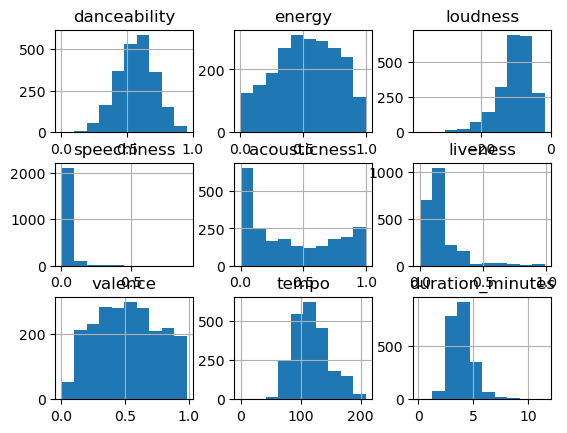

In [36]:
# looking at the distribution of some of the audio features of the songs played
tracks_df[['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'liveness', 'valence', 'tempo', 'duration_minutes']].hist()

Across the different song attributes in this week's worth of data, the distribution is mostly normal. There are some exceptions to this, notably speechiness (perhaps unsurprisingly, given that it's songs and not audiobooks being played), acousticness, liveness, and loudness.

### What were some popular songs/artists played throughout the week?

<AxesSubplot:>

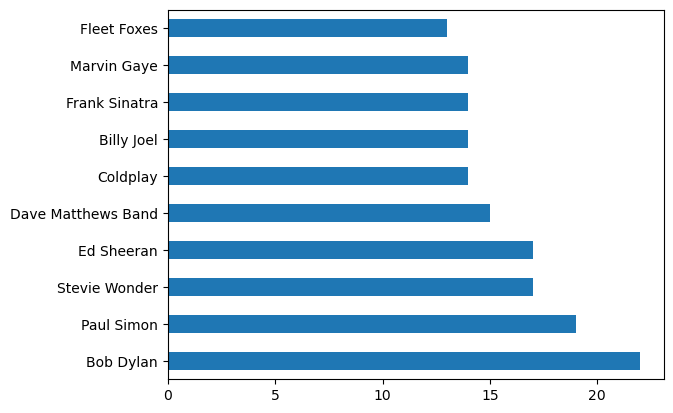

In [392]:
# in the week that i am analyzing, who was played the most (excluding John Mayer, who plays a lot of his own music)
tracks_df[tracks_df['artist'] != 'John Mayer']['artist'].value_counts().head(10).plot(kind = 'barh')

All excellent top played artists.

<AxesSubplot:>

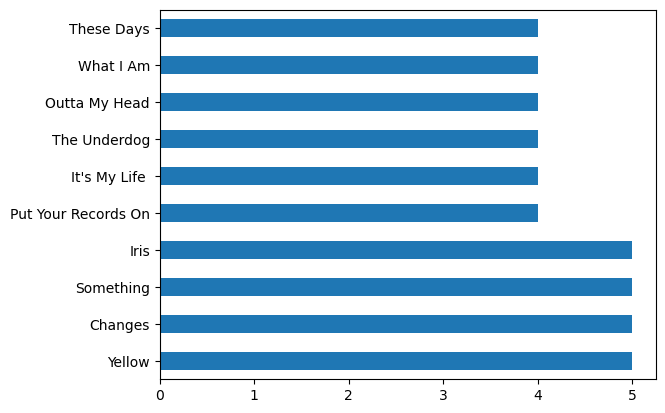

In [393]:
# what were the most frequently played tracks, aside from john mayer ones
tracks_df[tracks_df['artist'] != 'John Mayer']['track_name'].value_counts().head(10).plot(kind = 'barh')

<AxesSubplot:>

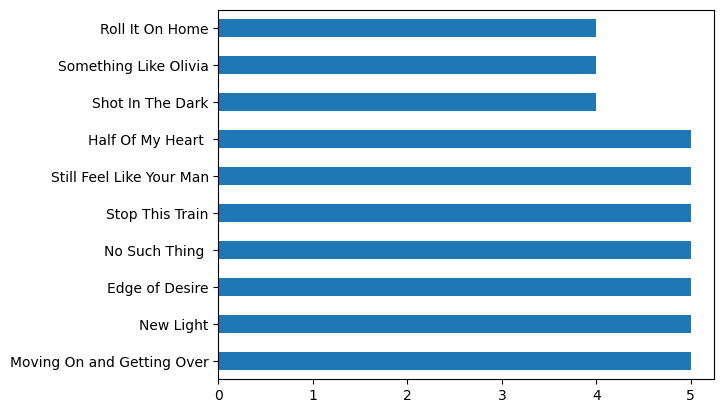

In [39]:
# how about the most played John Mayer tracks?
tracks_df[tracks_df['artist'] == 'John Mayer']['track_name'].value_counts().head(10).plot(kind = 'barh')

Looking at the above 2 charts, what sticks out to me is that no song is played more than 5 times. My assumption before conducting this analysis was that the max number of times a song was played would be higher, because it felt like I was hearing the same songs over and over, but I was wrong. That's what happens when you assume!

### Time Series Analysis

<AxesSubplot:xlabel='hour'>

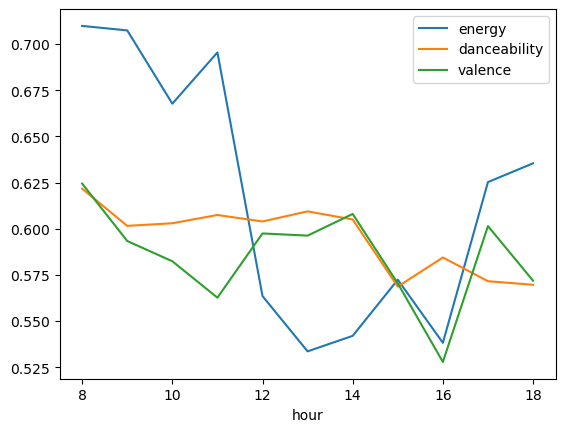

In [394]:
#looking at a typical workday, is there any trend in the energy of songs played?
#create an hour column
tracks_df['hour'] = tracks_df['start_time_est'].dt.hour

#group by the newly created hour column and find the mean
tracks_df[(tracks_df['start_time_est'].dt.day.isin([11,12,13,14,15]) == True) 
          & (tracks_df['start_time_est'].dt.hour >= 8)
         & (tracks_df['start_time_est'].dt.hour <= 18)].groupby('hour').mean().plot(kind = 'line', y=['energy','danceability','valence'])

In [478]:
tracks_df['hour'] = tracks_df['start_time_est'].dt.hour

#group by the newly created hour column and find the mean
tracks_df[(tracks_df['start_time_est'].dt.day.isin([11,12,13,14,15]) == True) 
          & (tracks_df['start_time_est'].dt.hour >= 8)
         & (tracks_df['start_time_est'].dt.hour <= 18)].groupby('hour').mean()[['energy','danceability','valence']]

,energy,danceability,valence
hour,,,
8,0.709821,0.621692,0.624436
9,0.707390,0.601545,0.593344
10,0.667710,0.602949,0.582367
11,0.695462,0.607436,0.562667
12,0.563513,0.603921,0.597434
13,0.533581,0.609392,0.596257
14,0.541985,0.605015,0.608000
15,0.572387,0.568653,0.570399
16,0.538208,0.584417,0.527861


During the workweek, the music played follows an interesting trend. The music played starts out high-energy. Throughout the day, the energy goes down before picking back up to end the day.

<AxesSubplot:xlabel='start_time_est'>

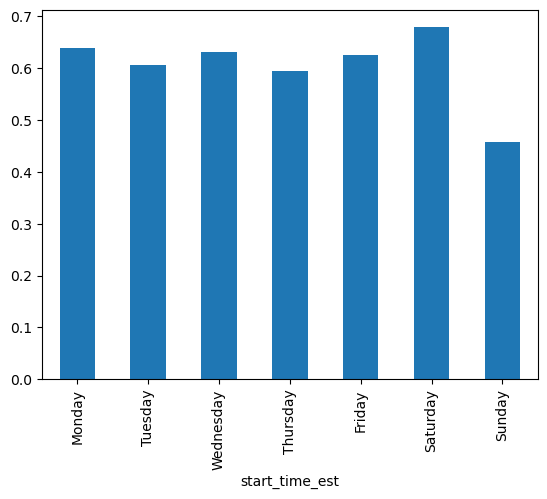

In [395]:
# how did the average level of energy of songs played vary by day?
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tracks_df[(tracks_df['start_time_est'].dt.hour >= 8) & 
          (tracks_df['start_time_est'].dt.hour <= 18)].groupby(tracks_df['start_time_est'].dt.day_name()).mean().loc[day_order]['energy'].plot(kind='bar')

<AxesSubplot:xlabel='start_time_est'>

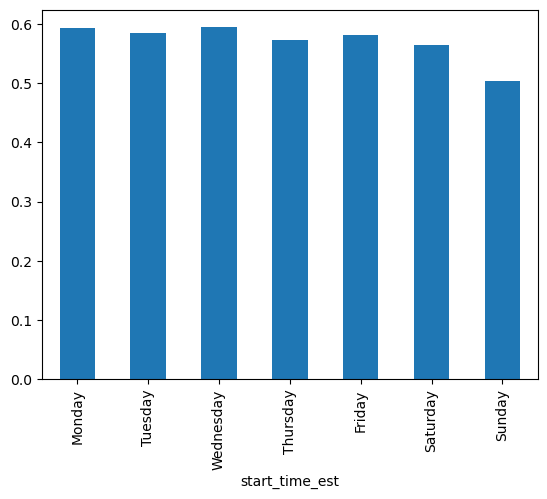

In [71]:
# how did the average level of valence (defined by spotify on a negative positive scale from 0 to 1) of songs played vary by day?
tracks_df[(tracks_df['start_time_est'].dt.hour >= 8) & 
          (tracks_df['start_time_est'].dt.hour <= 18)].groupby(tracks_df['start_time_est'].dt.day_name()).mean().loc[day_order]['valence'].plot(kind='bar')

The biggest takeaway looking at the above 2 charts is that the Sunday scaries are a real thing. Compared to the other days of the week, songs played on Sunday were on average more negative sounding as well as less energetic, catering to the moods of a population tired from a long weekend of activities and not looking forward to going to work the following day.

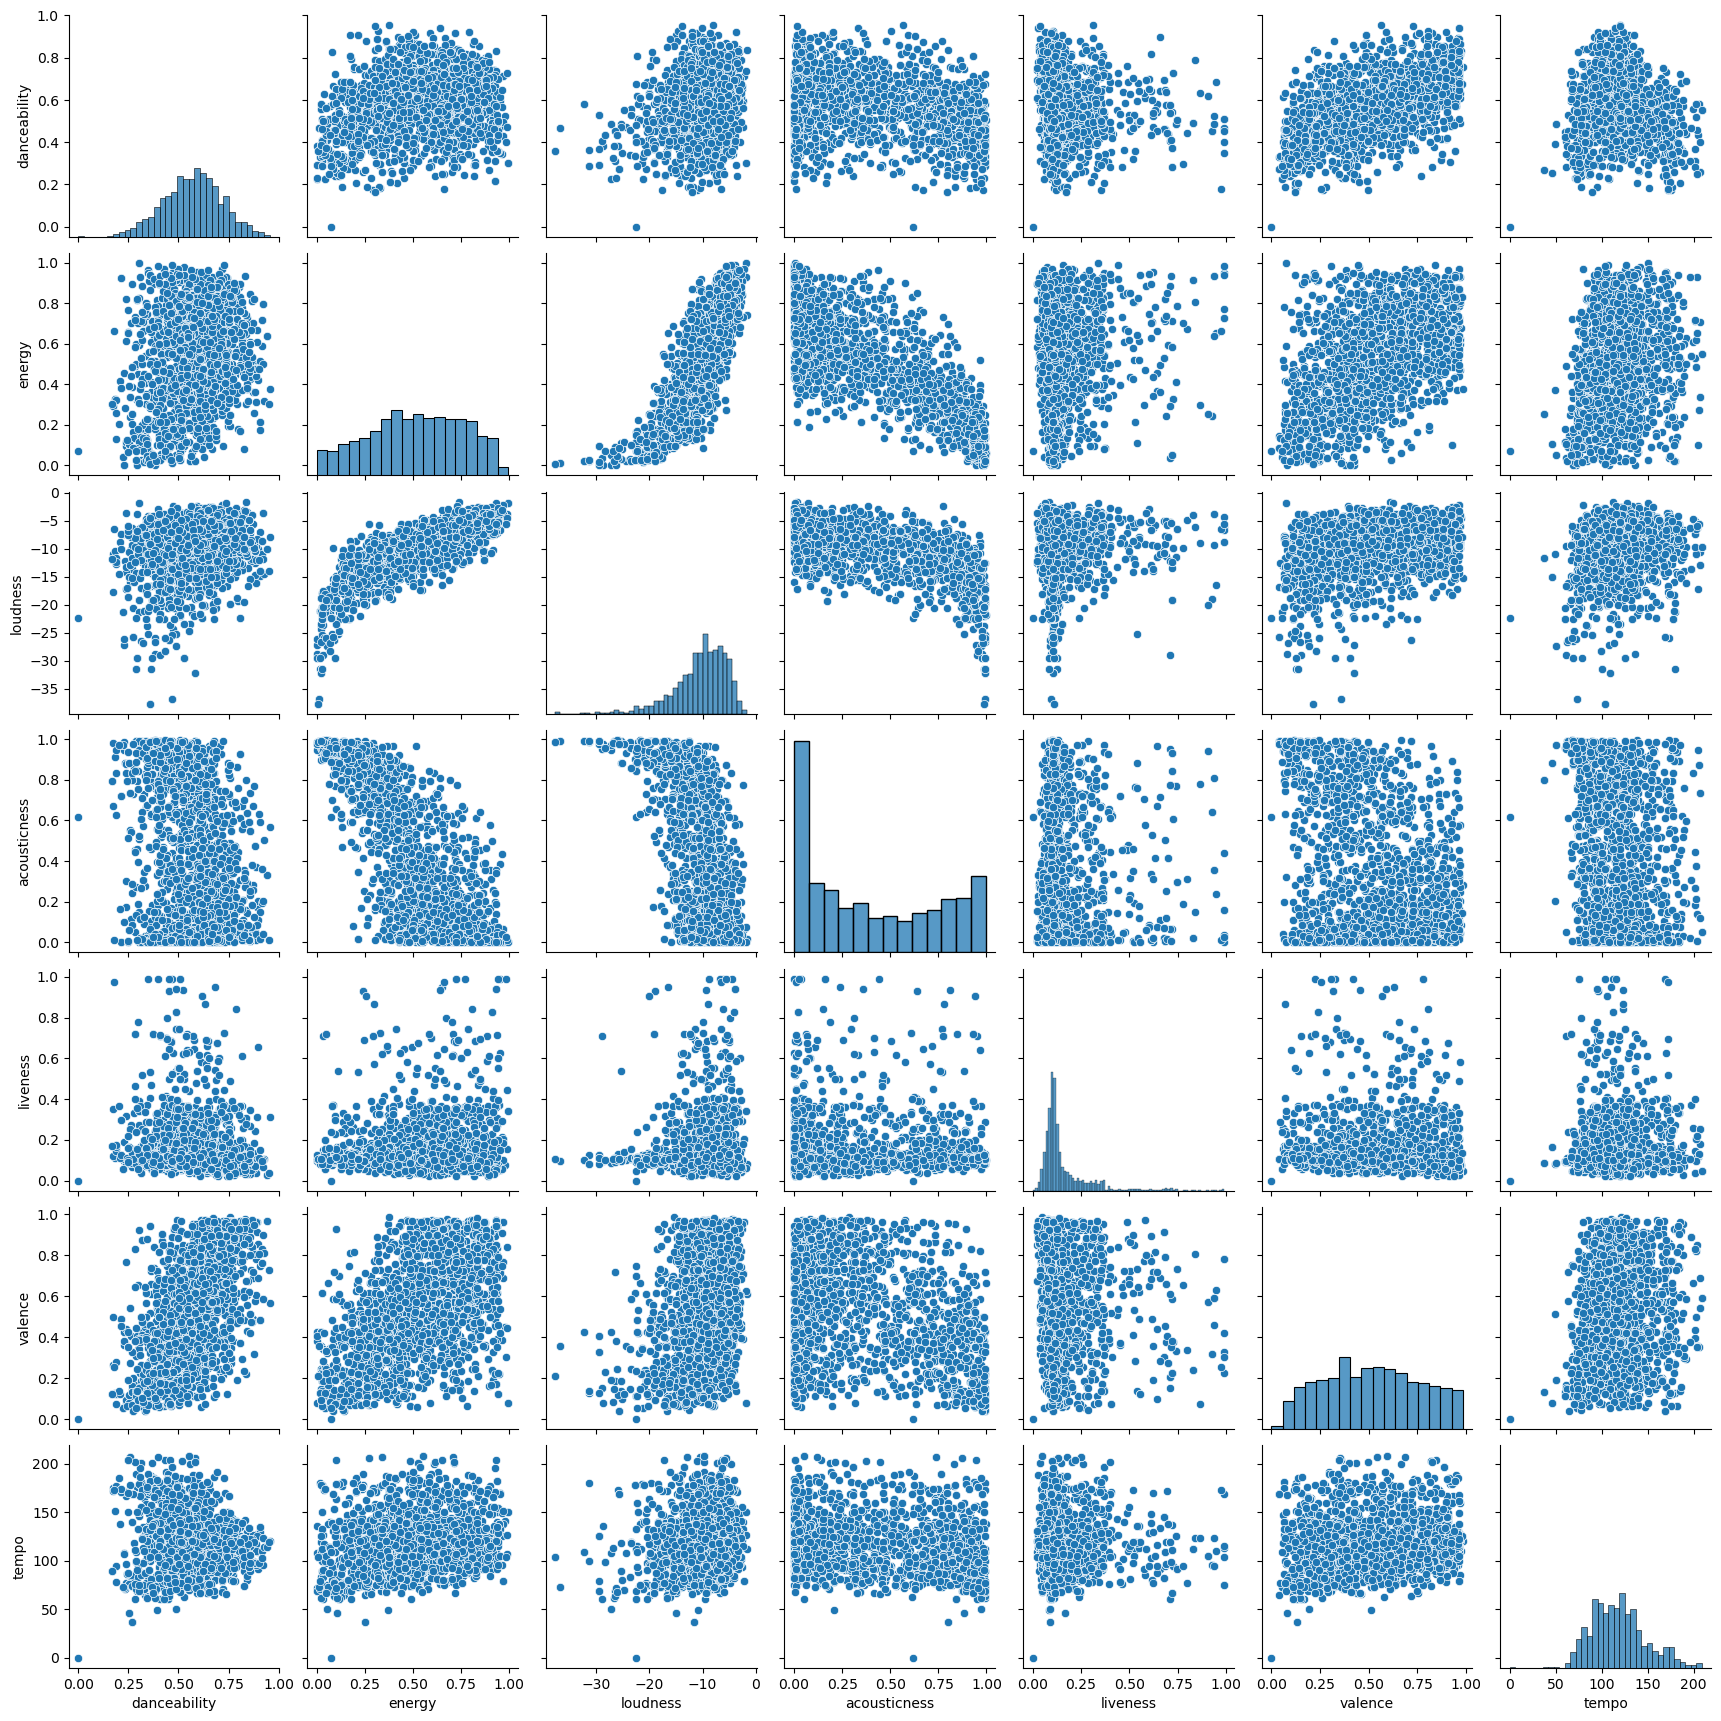

In [135]:
#here im curious to see how the different features of songs correlate with each other
sns.pairplot(tracks_df[['danceability', 'energy', 'loudness',
       'acousticness', 'liveness', 'valence', 'tempo']])

## Modelling
For the modelling portion of my project, I decided to implement a K-Means Cluster Analysis to see if the types of songs played on Life with John Mayer fell into distinct groupings.

In [446]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [397]:
# to start, I wanted to work with a DataFrame that was only unique songs that had audio feature data
# the below code creates a DataFrame with unique songs that have all of the data available
tracks_df_2 = tracks_df.dropna().drop(['start_time','start_time_est','hour'], axis = 1).drop_duplicates()

In [398]:
# i'm using my background knowledge here to decide what attributes in the dataset are worth including in a cluster
# analysis. that means excluding things like mode, duration, and key. while those are unique characteristics of a
# song, they aren't necessarily a part of a song's essence
X = tracks_df_2[['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

In [399]:
# scaling features to standardize them. tempo, for instance, has much higher values than most, which are on a scale
# from 0-1
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

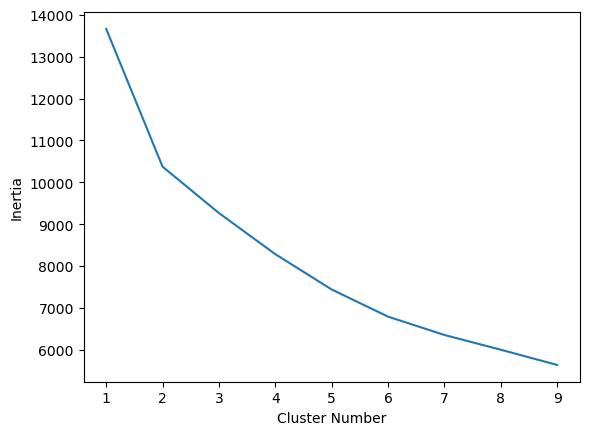

In [481]:
# using the elbow method to determine the appropriate number of clusters to examine
inertia_list = []
k_list = []

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    k_list.append(k)
    inertia_list.append(km.inertia_)
    
plt.plot(k_list, inertia_list)
plt.xlabel("Cluster Number")
plt.ylabel("Inertia");

This method is telling me that 2 clusters seems to be the appropriate amount to group my data into. Disappointing, as I thought there would be more nuance to look at, but let's roll with it!

In [444]:
km = KMeans(n_clusters=2, random_state=1)

In [445]:
km.fit(X_scaled)

KMeans(n_clusters=2, random_state=1)

In [436]:
#adding the labels to the unique song DataFrame
tracks_df_2['cluster'] = km.labels_

In [447]:
#pinpointing the cluster centers
centers = tracks_df_2.groupby('cluster').mean()[['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
centers

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,0.609269,0.662820,-8.018340,0.055286,0.197172,0.046289,0.177495,0.623751,121.107944
1,0.496853,0.267702,-14.451149,0.040239,0.744390,0.187810,0.146876,0.336630,111.994665


**The 2 clusters have the following general characteristics:**
1) The first cluster, I would describe as upbeat, dancey, feel-good music.

In [439]:
song_clusters = tracks_df_2.sort_values('cluster')

In [450]:
# let's look at a sample of 20 songs from this cluster to see if that is true
cluster_1 = tracks_df_2[tracks_df_2['cluster'] == 0][['track_name','artist','cluster','danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].iloc[:20]
cluster_1

,track_name,artist,cluster,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
6,Forget About Georgia,Lukas Nelson & Promise Of The Real,0,0.624,0.599,-6.530,0.0293,0.2410,0.031800,0.1830,0.297,128.861
10,Threnody,Goldmund,0,0.774,0.456,-10.804,0.1430,0.1400,0.875000,0.1040,0.383,85.044
12,Something,The Beatles,0,0.392,0.463,-7.021,0.0292,0.1490,0.000000,0.0854,0.422,132.346
14,Distant Lover,Marvin Gaye,0,0.503,0.427,-9.155,0.0293,0.4160,0.003390,0.0727,0.543,141.924
19,What Was It You Wanted,Willie Nelson,0,0.509,0.727,-8.822,0.0458,0.1610,0.032500,0.9910,0.781,74.773
22,Motel 6,River Whyless,0,0.683,0.733,-7.212,0.0475,0.2310,0.000420,0.1000,0.787,138.929
28,Africa,D'Angelo,0,0.726,0.330,-9.935,0.2140,0.6070,0.125000,0.7240,0.376,94.755
32,Ballad Of Sir Frankie Crisp (Let It Roll),George Harrison,0,0.432,0.584,-9.675,0.0284,0.0723,0.429000,0.1290,0.449,89.745
51,The Barrel,Aldous Harding,0,0.732,0.408,-8.475,0.0360,0.7470,0.000229,0.0690,0.663,87.015
59,When I Get My Hands on You,The New Basement Tapes,0,0.906,0.213,-13.936,0.0789,0.0174,0.075300,0.0986,0.485,135.309


Looking at a sampling of these songs, I see some interesting things not necessarily about the songs played on the station, but rather the way Spotify classifies these songs, and how it has some flaws. For instance, When I Get My Hands on You by The New Basement Tapes has a danceability score of 0.906. Give that song a listen, it is not danceable at all! Or how about Wagon Wheel by Old Crow Medicine Show? That entire song is essentially an acoustic guitar and a fiddle, yet it only has an acousticness of 0.581.

Setting aside questions about the way Spotify scores various tracks, let's take a look at a sample of songs from the second cluster:

2) Based on the mean values in this cluster, I would categorize it as slow, meditative, acoustic ballads.

In [451]:
cluster_2 = tracks_df_2[tracks_df_2['cluster'] == 1][['track_name','artist','cluster','danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].iloc[:20]
cluster_2

,track_name,artist,cluster,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Going To California,Led Zeppelin,1,0.503,0.26500,-15.913,0.0333,0.943,0.045000,0.0867,0.5220,78.044
1,I'll Be Seeing You,Billie Holiday,1,0.355,0.03040,-20.479,0.0361,0.989,0.055500,0.1160,0.1880,90.495
2,Unknown/Nth,Hozier,1,0.475,0.17800,-9.976,0.0347,0.745,0.000189,0.0899,0.2300,136.687
3,Some,Nils Frahm,1,0.358,0.00527,-37.703,0.0407,0.985,0.890000,0.1080,0.2120,103.791
4,When The Stars Go Blue,Ryan Adams,1,0.590,0.20800,-13.250,0.0316,0.466,0.000028,0.1150,0.2930,90.084
5,September In The Rain,Dinah Washington,1,0.401,0.21300,-13.124,0.0545,0.346,0.000010,0.0596,0.6780,110.611
7,Place to Be,Nick Drake,1,0.547,0.38000,-9.521,0.0282,0.865,0.152000,0.1070,0.3950,83.579
8,"Bewitched, Bothered, and Bewildered",Ella Fitzgerald,1,0.344,0.10800,-16.631,0.0475,0.971,0.000000,0.0961,0.2630,61.188
9,Old Friend,Toots Thielemans,1,0.243,0.12600,-17.056,0.0310,0.797,0.771000,0.1130,0.0662,86.384
11,Spanish Is the Loving Tongue,Bob Dylan,1,0.555,0.20900,-13.705,0.0336,0.977,0.000606,0.1060,0.3020,126.459


Looking at this sampling of songs, I think that characterization holds true! 

Let's use some visualization tools to see if we can see these clusters in a more visual way.

In [452]:
song_clusters_df = pd.concat([cluster_1, cluster_2])

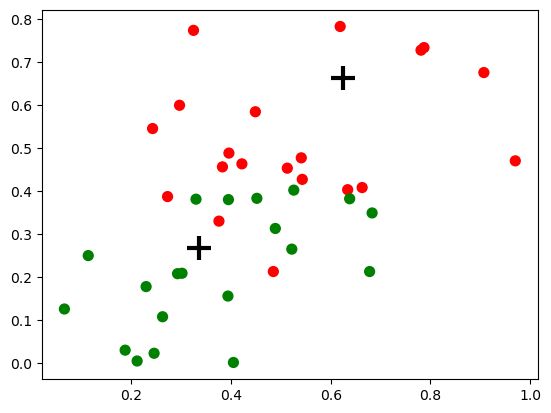

In [453]:
colors = np.array(['red','green'])
plt.scatter(song_clusters_df['valence'], song_clusters_df['energy'], c=colors[song_clusters_df['cluster']], s=50)

plt.scatter(centers['valence'], centers['energy'], linewidths=3, marker='+', s=300, c='black')

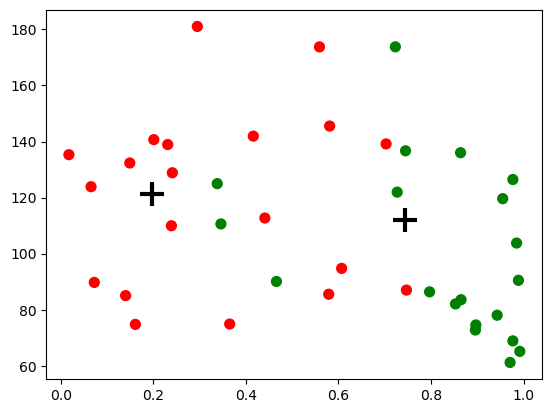

In [454]:
colors = np.array(['red','green'])
plt.scatter(song_clusters_df['acousticness'], song_clusters_df['tempo'], c=colors[song_clusters_df['cluster']], s=50)

plt.scatter(centers['acousticness'], centers['tempo'], linewidths=3, marker='+', s=300, c='black')